# Comparing my implementations 

There is a MaxEnt toolbox in [matlab](https://github.com/orimaoz/maxent_toolbox) and I want to see whether the models I make using my code are the same as the models trained using the matlab tool box.

## Read in Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import njit, prange
from math import comb

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Baskerville']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 12 

In [3]:
data = np.loadtxt("Data/repeat_shuffle_train.csv", delimiter=",", dtype=int)

In [4]:
train = data[:10,:] # first 10 neurons outputs

In [5]:
N, M = train.shape
N, M

(10, 226814)

## Get expectations needed for models

### Avgs

In [6]:
avgs = np.mean(train,axis=1) # get the mean firing of neurons

In [7]:
avgs

array([0.02780693, 0.0081256 , 0.01418784, 0.01658628, 0.02141843,
       0.02126412, 0.02441648, 0.08030809, 0.04152742, 0.00597847])

### Correlations

In [8]:
@njit(parallel=True)
def correlations(arr):
    N, M = arr.shape
    corrs = np.zeros((N,N))
    for i in prange(N-1):
        for j in prange(i+1,N):
            corrs[i,j]=np.sum(arr[i]*arr[j])    
    return corrs / M

In [9]:
corr_mat = correlations(train) #correlation matrix
corrs = corr_mat[np.triu_indices_from(corr_mat,k=1)]

### P(K)

In [10]:
counts = np.sum(train,axis=0) # how many neurons fires in each bin
count_freq = np.bincount(counts) # tallies how many states with 0, 1, ... N neurons firing there are 
p_k = np.zeros(N+1)
for i in range(len(count_freq)): 
    p_k[i] = count_freq[i]/M 

In [11]:
np.max(counts), p_k

(5,
 array([7.90502350e-01, 1.67084042e-01, 3.40278819e-02, 7.15564295e-03,
        1.13749592e-03, 9.25868774e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

## Train models 

In [12]:
from MaxEnt import Independent, PopCount, Ising

### Independent

In [48]:
indep = Independent(N, avgs) 

In [49]:
# compare to weights from matlab
mat_indep = np.loadtxt("ModelWeights/indep.csv", delimiter=",", dtype=float)

In [50]:
def compare_weights(ours, theirs):
    plt.plot(ours,theirs,".")
    plt.xlabel("Our weights")
    plt.ylabel("Maxent toolbox weights")
    plt.title("Comparison of weights")
    plt.show()

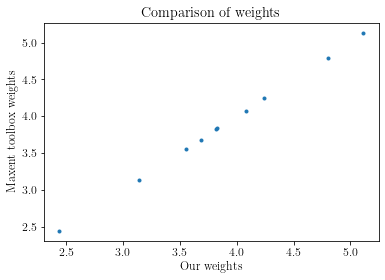

In [51]:
compare_weights(indep.h,mat_indep)

In [52]:
indep.h

array([3.55426931, 4.80457683, 4.2410808 , 4.0824542 , 3.82185233,
       3.8292407 , 3.68777737, 2.43816832, 3.13898705, 5.1135947 ])

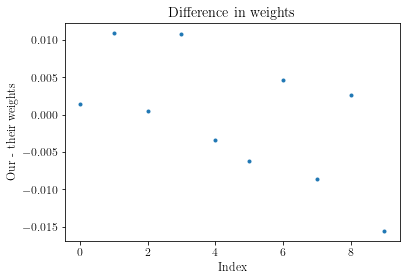

In [53]:
plt.plot(range(len(mat_indep)), indep.h-mat_indep,".")
plt.xlabel("Index")
plt.ylabel("Our - their weights")
plt.title("Difference in weights")
plt.show()

Compare the predicted distributions

In [163]:
def compare_dist(ours, theirs, xlab="Our model",ylab="Maxent toolbox",):
    plt.loglog(ours,theirs,".")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title("Comparison of probability of each state")
    plt.show()

In [164]:
p_mat_states = np.loadtxt("ModelWeights/indep_dist.csv", delimiter=",", dtype=float) # their predicted prob. of each state
p_states = indep.p(indep.states)  # use our model to predict the probability of each state 
p_flip_states = indep.p(np.flip(indep.states, 1)) # use our model to predict states but flip their representations

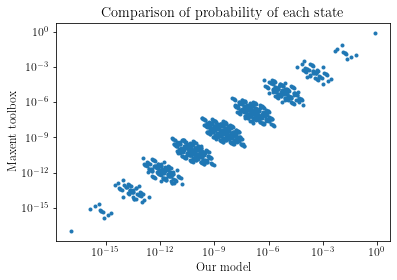

In [165]:
compare_dist(p_states,p_mat_states)

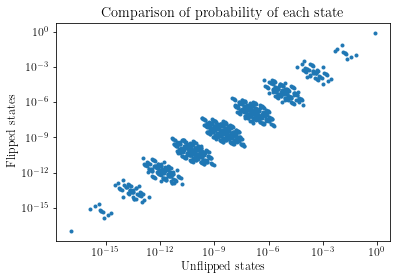

In [166]:
compare_dist(p_states,p_flip_states,"Unflipped states", "Flipped states")

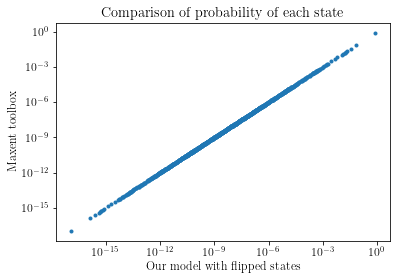

In [167]:
compare_dist(p_flip_states,p_mat_states,"Our model with flipped states")

## P(K)
We get very different values for the model parameters for this model. We clearly store very different things here. 

In [168]:
pop = PopCount(N,p_k)

In [169]:
pop.p_K

array([7.90502350e-01, 1.67084042e-01, 3.40278819e-02, 7.15564295e-03,
       1.13749592e-03, 9.25868774e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [170]:
combs = np.array([comb(N,K) for K in np.arange(N+1)])
V_k = -np.log(pop.p_K[:6]/combs[:6])

In [171]:
mat_pk = np.loadtxt("ModelWeights/ksync.csv", delimiter=",", dtype=float)
mat_pk

array([-10.87632627,  -7.01693709,  -3.92024683,  -1.38597437,
         1.0246631 ,   3.82314003,   5.62309806,   5.16611673,
         4.18190619,   2.65609283,   0.72446768])

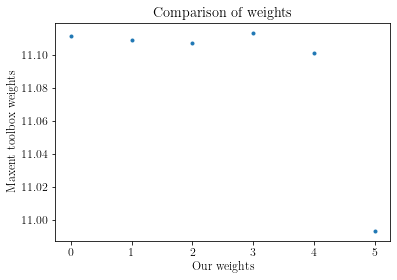

In [172]:
plt.plot(range(6),V_k[:6]-mat_pk[:6],".")
plt.xlabel("Our weights")
plt.ylabel("Maxent toolbox weights")
plt.title("Comparison of weights")
plt.show()

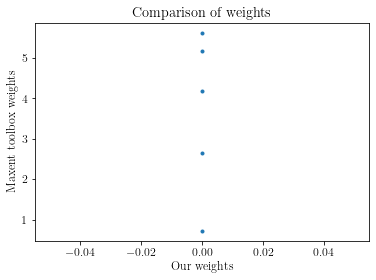

In [173]:
plt.plot(pop.p_K[6:], mat_pk[6:],".")
plt.xlabel("Our weights")
plt.ylabel("Maxent toolbox weights")
plt.title("Comparison of weights")
plt.show()

The difference between the two should be equal to the log of the partition function. We can calculate this as $\sum_K \exp (-V_K)\cdot {N \choose K}$

In [174]:
Z = np.sum(np.exp(-mat_pk)*combs)

In [175]:
for K in range(N+1):
    print("P(K)=", np.exp(-mat_pk)[K]/Z*combs[K], pop.p_K[K])

P(K)= 0.7909224053217281 0.7905023499431252
P(K)= 0.16673334153956051 0.16708404243124322
P(K)= 0.03391247387239906 0.034027881876780096
P(K)= 0.0071731128184065315 0.007155642949729734
P(K)= 0.0011267281875987332 0.0011374959217684976
P(K)= 8.234501592651241e-05 9.25868773532498e-05
P(K)= 1.1343425745118349e-05 0.0
P(K)= 1.0236951682100818e-05 0.0
P(K)= 1.0271624324961279e-05 0.0
P(K)= 1.0497332083652326e-05 0.0
P(K)= 7.2439105450143985e-06 0.0


Though the first few weights seem to agree nicely, notice, the latter half of weights don't. This is because of their implementation where weights are determined numerically as opposed to analytically, and the fact that in order to get $P(0)$, the argument of the exponential needs to go to negative infinity.
Fortunately, we can map between our representations as below:

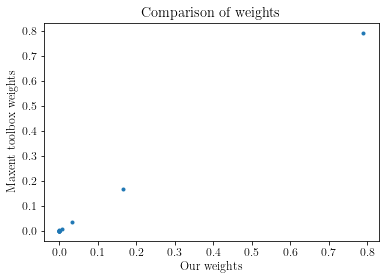

In [176]:
plt.plot(pop.p_K, np.exp(-mat_pk)*combs/Z,".")
plt.xlabel("Our weights")
plt.ylabel("Maxent toolbox weights")
plt.title("Comparison of weights")
plt.show()

In [177]:
mat_states = np.loadtxt("ModelWeights/ksync_dist.csv", delimiter=",", dtype=float)
p_states = pop.p(pop.states)

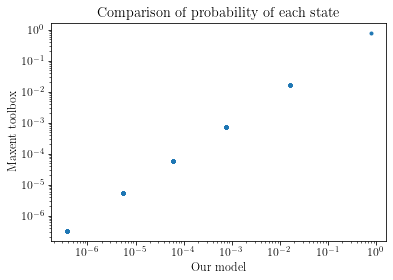

In [178]:
plt.loglog(p_states[p_states>0],mat_states[p_states>0],".") # we only compare the states with non-zero probability
plt.xlabel("Our model")
plt.ylabel("Maxent toolbox")
plt.title("Comparison of probability of each state")
plt.show()

### Pairwise model

In [179]:
ising = Ising(N, avgs, corr_mat, lr=0.5) 

In [223]:
ising.gradient_ascent() # 500 steps 
corr_diff =  ising.correlations() - corr_mat
flat_corr = corr_diff[np.triu_indices_from(corr_diff,1)]
print("Difference in averages:", ising.averages() - avgs, "Difference in correlations:", flat_corr, sep="\n")

Difference in averages:
[-3.99135719e-09  2.52440698e-06  1.76210344e-06  4.24538451e-07
 -1.84790645e-07  5.00222867e-07  1.76972355e-07 -1.21079591e-07
  1.75257167e-07  5.17358432e-06]
Difference in correlations:
[-7.31148783e-07  1.46239578e-06  1.08808953e-05 -3.13623823e-07
  1.76361791e-07  3.17000002e-07 -2.20507356e-07  4.75970525e-09
 -7.43166820e-06 -1.88349969e-05 -4.47652915e-05  4.95003551e-06
 -2.99100194e-05  7.53574115e-06  6.87814788e-06 -1.95577780e-05
 -1.84629203e-05 -5.45420372e-06  7.96640978e-07  4.98640117e-07
 -1.65480583e-06 -6.35853272e-07  8.27350817e-07 -5.83658480e-05
  2.88957102e-06 -1.64001020e-06  4.51396130e-06  5.86016931e-07
 -4.66821992e-07  9.68596777e-06  1.20749225e-06 -1.19203200e-07
 -2.36570165e-07  2.85429894e-07 -1.76728330e-05 -5.38340254e-07
  2.80306303e-07 -5.71099197e-07 -3.67343859e-05 -4.37068567e-08
 -7.42032522e-07 -4.22948558e-05  1.25004184e-07  8.41253439e-06
 -1.76430280e-05]


Compare local fields:

In [224]:
ising.h

array([3.75423147, 4.94192949, 4.64797138, 4.14123003, 4.53425768,
       4.09724296, 3.79024437, 2.65818322, 3.21856211, 5.09181697])

In [225]:
mat_ising = np.loadtxt("ModelWeights/m_pwise.csv", delimiter=",", dtype=float)

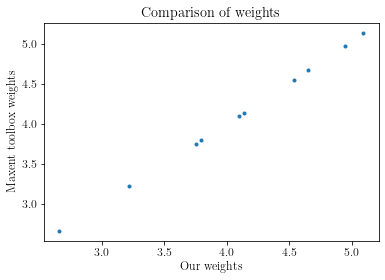

In [226]:
plt.plot(ising.h,mat_ising[:N],".")
plt.xlabel("Our weights")
plt.ylabel("Maxent toolbox weights")
plt.title("Comparison of weights")
plt.show()

In [227]:
ising.J

array([[ 0.        , -0.36418172, -1.58154737,  0.80657289, -1.03912041,
        -0.10391108, -0.31241796, -0.75556128,  0.21063456, -0.7126939 ],
       [ 0.        ,  0.        , -0.43890669, -0.55337162, -1.09556472,
        -0.40642547,  0.60851352, -0.58137139,  0.37135776,  0.50535466],
       [ 0.        ,  0.        ,  0.        , -0.58816072, -2.09248827,
        -0.49316442, -0.74613697, -0.53124745,  0.73039234, -1.4249553 ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.94576861,
        -0.61993351,  0.46747231, -0.39045532,  0.81436474,  0.62298036],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.26189087, -0.45118164, -1.97415683, -0.43921271,  0.27199648],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.73526644, -0.69807468,  0.32882465,  0.605648  ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.04683542

In [228]:
def flatten_corr(corr):
    N = len(corr)
    flat_corr = np.zeros(N*(N-1)//2)
    k = 0
    for i in range(N-1): # go through each row 
        for j in range(i+1,N): # go through each column
            flat_corr[k] = corr[i,j]
            k+=1
    return flat_corr

In [229]:
flat_J = flatten_corr(ising.J)

We are not sure how they have collapsed all pairwise interactions into an array, so we are going to try figure that out. 

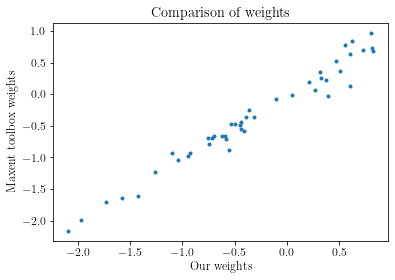

In [230]:
plt.plot(flat_J,mat_ising[N:],".")
plt.xlabel("Our weights")
plt.ylabel("Maxent toolbox weights")
plt.title("Comparison of weights")
plt.show()

In [231]:
p_states = ising.p(np.flip(ising.states, 1))

In [232]:
mat_states= np.loadtxt("ModelWeights/m_pwise_dist.csv", delimiter=",", dtype=float)

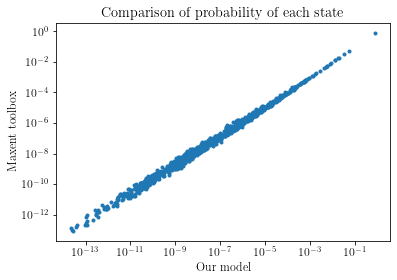

In [234]:
compare_dist(p_states,mat_states)